# Load packages

In [1]:
import sys
sys.path.append("..")

import jax, os, corner
import jax.numpy as jnp
from jax import grad, config
import matplotlib.pyplot as plt
import numpy as np
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)
from functools import partial

# Load reparameterization methods
from src.reparameterization import reparameterization, sigma, logistic_CDF

# Load model module

In [ ]:
from models.JAXHRD import hybrid_rosenbrock

# Model definition
n2 = 3
n1 = 4
DoF = n2 * (n1 - 1) + 1
B = np.zeros(DoF)
B[0] = 30
B[1:] = 20
mu=1
model = hybrid_rosenbrock(n2, n1, mu, B, seed=35)

# Rejection sampling to draw samples from bounded domain
iid_samples = model.newDrawFromPosterior(10000000)
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

In [ ]:
### Define gravitational wave model ###

from models.taylorf2 import taylorf2

# Toy problem
# injection = jnp.array([0, 0, 30.0, 0.24, 0.05]) 

# Prior ranges without exponentially suppressed modes
# priorDict = {}
# priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
# priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([27.5, 32.5])
# priorDict[3] = jnp.array([0.2, 0.249])
# priorDict[4] = jnp.array([0.02, 0.07])

# Prior range with exponentially suppressed modes
# priorDict = {}
# priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
# priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([20, 40])
# priorDict[3] = jnp.array([0.1, 0.249]) 
# priorDict[4] = jnp.array([0.02, 0.07])

# Emulation of a binary neutron star system 
injection = jnp.array([0, 0, 1.2, 0.245, 0.05]) 

priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
# priorDict[2] = jnp.array([1.1, 1.3]) # Either a stepsize < 1e-6 is needed, or a grid finer than 1000 is needed. Or both!
priorDict[2] = jnp.array([1.19, 1.21])

priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])

model = taylorf2(injection, priorDict)
print('n_bins=%i' % model.n_bins)

In [ ]:
from models.taylorf2_spin import taylorf2
### SPIN ###
# Emulation of a binary neutron star system 
injection = jnp.array([0, 0, 1.2, 0.245, 0.05, 0.0, 0.0]) 

priorDict = {}
priorDict[0] = injection[0] + jnp.array([-0.001, 0.001])
priorDict[1] = jnp.array([-jnp.pi, jnp.pi])
priorDict[2] = jnp.array([1.19, 1.21]) 
priorDict[3] = jnp.array([0.2, 0.249])
priorDict[4] = jnp.array([0.02, 0.07])
# priorDict[5] = jnp.array([-0.5, 1]) * 0.98 
# priorDict[6] = jnp.array([0, 1]) * 0.98

priorDict[5] = jnp.array([0, 0.2]) 
priorDict[6] = jnp.array([0.1, 0.3])

model = taylorf2(injection, priorDict)
print('n_bins=%i' % model.n_bins)

1000000 samples obtained from rejection sampling


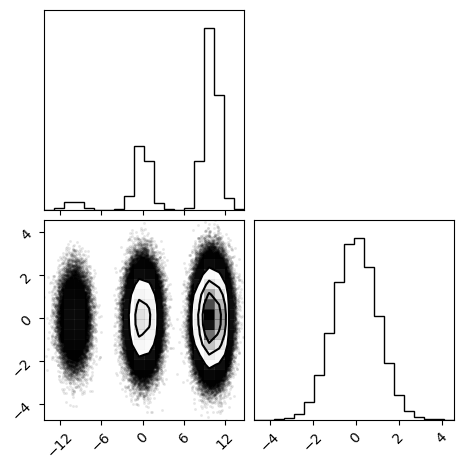

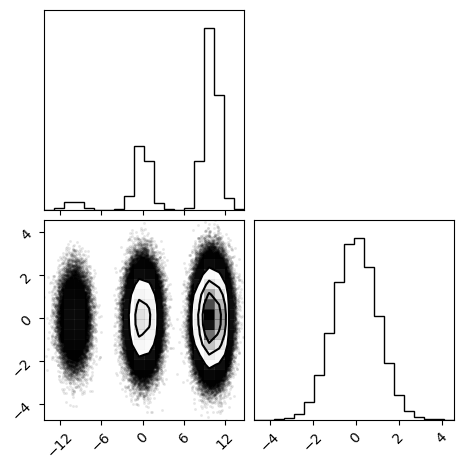

In [44]:
# Mixture of Gaussian model!

from models.mog_new import MoG 

k = 3
d = 2
weights = jnp.array([2, 4, 5])

mus = jnp.zeros((k, d))
mus = mus.at[0].set(jnp.array([-10, 0]))
mus = mus.at[1].set(jnp.array([0, 0]))
mus = mus.at[2].set(jnp.array([10, 0]))

covs = jnp.zeros((k, d, d))
covs = covs.at[0].set(jnp.eye(d))
covs = covs.at[1].set(jnp.eye(d))
covs = covs.at[2].set(jnp.eye(d))

model = MoG(weights, mus, covs)

model.lower_bound = jnp.array([-15, -15])
model.upper_bound = jnp.array([15, 15])

iid_samples = model.newDrawFromPosterior(1000000)

# Rejection sampling to draw samples from bounded domain
truth_table = ((iid_samples > model.lower_bound) & (iid_samples < model.upper_bound))
idx = np.where(np.all(truth_table, axis=1))[0]
print('%i samples obtained from rejection sampling' % idx.shape[0])
bounded_iid_samples = iid_samples[idx]

corner.corner(bounded_iid_samples)


In [ ]:
def getCrossSection(index1, index2, func, ngrid, DoF=5):
    # a, b are the parameters for which we want the marginals:
    x = np.linspace(priorDict[index1][0], priorDict[index1][1], ngrid)
    y = np.linspace(priorDict[index2][0], priorDict[index2][1], ngrid)
    X, Y = np.meshgrid(x, y)
    particle_grid = np.zeros((ngrid ** 2, DoF))
    parameter_mesh = np.vstack((np.ndarray.flatten(X), np.ndarray.flatten(Y))).T
    particle_grid[:, index1] = parameter_mesh[:, 0]
    particle_grid[:, index2] = parameter_mesh[:, 1]
    for i in range(DoF): # Fix all other parameters
        if i != index1 and i != index2:
            particle_grid[:, i] = np.ones(ngrid ** 2) * injection[i]
    Z = func(particle_grid).reshape(ngrid,ngrid)
    fig, ax = plt.subplots(figsize = (5, 5))
    cp = ax.contourf(X, Y, Z)
    plt.colorbar(cp)
    ax.set_xlabel(index1)
    ax.set_ylabel(index2)
    ax.set_title('Likelihood cross section')
    filename = str(index1) + str(index2) + '.png'
    path = os.path.join('marginals', filename)
    # fig.savefig(path)

posterior = lambda X: np.exp(-1 * model.getMinusLogPosterior_ensemble(X))

neg_potential = lambda X: -1 * model.getMinusLogPosterior_ensemble(X)

# getCrossSection(1, 2, neg_potential, 100)

for i in range(5):
    for j in range(i+1, 5):
        # print('Getting cross section for %s' % pair)
        # getCrossSection(i, j, posterior, 100)
        getCrossSection(i, j, neg_potential, 100)

# Define JAX based flow

In [3]:
# Batched birth-death implementation for GPU

def batched_birth_death(key, Y, V, tau, h):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    Notes
    -----

    # Get particles with significant mass discrepancy (2)
    tmp1 = jnp.mean(kern_bd, axis=1)
    Lambda = jnp.log(tmp1) + V
    Lambda = Lambda - jnp.mean(Lambda) - 1 + jnp.mean(kern_bd / tmp1, axis=1)
    
    """
    nParticles = V.shape[0]
    key, subkey = jax.random.split(key)

    # Lp kernel implementation
    def k_lp(X, p=2, h=0.001): 
        # Get separation vectors
        separation_vectors = X[:, jnp.newaxis, :] - X[jnp.newaxis, :, :]
        
        # Calculate kernel
        k = jnp.exp(-jnp.sum(jnp.abs(separation_vectors) ** p, axis=-1) / (p * h))
        return k

    kern_bd = k_lp(Y, h=h)

    # Get particles with significant mass discrepancy (1)
    beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    Lambda = beta - jnp.mean(beta) 

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    threshold = r < 1 - jnp.exp(-jnp.abs(Lambda) * tau)

    excess_particles = jnp.logical_and(threshold, Lambda > 0)
    deficit_particles = jnp.logical_and(threshold, Lambda < 0)

    # Excess density jumps
    randomized_indicies = jax.random.permutation(key, jnp.arange(nParticles))
    output = jnp.where(excess_particles, randomized_indicies, jnp.arange(nParticles)) 

    # Deficit density jumps
    random_mask = jax.random.permutation(subkey, deficit_particles)
    track = jax.random.permutation(subkey, jnp.arange(nParticles))
    output = jnp.where(random_mask, track, output) 

    return output

In [ ]:
# Confirming linalg library behaves as expected
from jax.scipy.linalg import solve_triangular, cholesky, cho_solve

key = jax.random.PRNGKey(0)
mock_hessian = jax.random.uniform(key, shape=(5,3,3)) + 5 * jnp.eye(3)[jnp.newaxis, ...] # Ensure p.d
mock_upper = cholesky(mock_hessian, lower=False) # This indeed performs batch operations

# Check that cholesky does batch operation properly
print(np.allclose(cholesky(mock_hessian[3]), mock_upper[3]))

# Check that triangular solve does batch properly
gauss = jax.random.normal(key, (5,3))
mock_noise = solve_triangular(mock_upper, gauss, lower=False) 
print(np.allclose(solve_triangular(mock_upper[3], gauss[3]), mock_noise[3]))

# Check that cho_solve does batch properly
mock_descent = cho_solve((mock_upper, False), gauss) # Ensure that this returns batch result as well
print(np.allclose(mock_descent[3], cho_solve((mock_upper[3], False), gauss[3])))

# Conclusion: Indeed, everything works as expected!

# Careful version of unadjusted quasi newton

In [ ]:
from src.reparameterization import reparameterization_full
from jax.scipy.linalg import solve_triangular, cholesky, cho_solve, solve

def uqn_kernel(key, param, log_post, grad_log_post, dt, iteration, gnhess, stride=100):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) stride = 1 will run birth-death at every iteration!
    
    """
    N = param.shape[0]
    d = param.shape[1]

    key, subkey = jax.random.split(key)

    V_X = log_post(param)

    paramGrad = grad_log_post(param)

    hess_X = gnhess(param)

    # Transform to unbounded domain (currently includes potential calculation for eventual birth-death step)
    Y, V_Y, gmlpt_Y, Hmlpt_Y = reparameterization_full(param, V_X, paramGrad, hess_X, model.lower_bound, model.upper_bound)

    Hmlpt_Y += 0.001 * jnp.eye(d)[jnp.newaxis, ...]
    U = cholesky(Hmlpt_Y, lower=False)

    # Perform jumps in unbounded domain
    # jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: batched_birth_death(key, Y, V_Y, dt * stride, h=0.001), lambda: jnp.arange(param.shape[0]))
    jumps = jnp.arange(N)

    # Perform update in unbounded domain
    Y = Y[jumps] - dt * solve(Hmlpt_Y, gmlpt_Y)[jumps] + jnp.sqrt(2 * dt) * solve(U, jax.random.normal(key=subkey, shape=(param.shape)))[jumps]
    # Y = Y[jumps] - dt * cho_solve((U, False), gmlpt_Y)[jumps] + jnp.sqrt(2 * dt) * solve_triangular(U, jax.random.normal(key=subkey, shape=(param.shape)), lower=False)[jumps]
    # Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(Y), model.lower_bound, model.upper_bound)

    iteration = iteration + 1

    return key, param, iteration


@partial(jax.jit, static_argnums=(1,2,3,6))
def uqn_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0, gnhess):

    # @progress_bar_scan(n_iter)
    def uqn_step(carry, x):
        key, param, iteration = carry
        key, param, iteration = uqn_kernel(key, param, log_post, grad_log_post, dt, iteration, gnhess, stride=100)
        return (key, param, iteration), param

    carry = (key, x_0, 0)
    _, samples = jax.lax.scan(uqn_step, carry, None, n_iter)
    return samples

###############################
# n_iter = 2000
# n_particles = 100
# eps = 1e-3
# X0 = model._newDrawFromPrior(n_particles)
# key = jax.random.PRNGKey(0)
# # Run sampler
# # sam = uqn_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0, jax.vmap(model.fisher_single))
# sam = uqn_sampler_full_jax_jit(key, model.getMinusLogPosterior_ensemble, model.getGradientMinusLogPosterior_ensemble, n_iter, eps, X0, jax.vmap(model.getGNHessianMinusLogPosterior))


In [ ]:
n_iter = 10000
n_particles = 100
eps = 1e-4
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)
# Run sampler
sam = uqn_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0, jax.vmap(model.fisher_single))
# sam = uqn_sampler_full_jax_jit(key, model.getMinusLogPosterior_ensemble, model.getGradientMinusLogPosterior_ensemble, n_iter, eps, X0, jax.vmap(model.getGNHessianMinusLogPosterior))

In [ ]:
sam = uqn_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1], jax.vmap(model.fisher_single))

In [ ]:
# Plot samples
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-10000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection) # For taylorf2
# fig = corner.corner(reshaped_matrix[-20000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
# corner.corner(bounded_iid_samples[-20000:], color='r', fig=fig, hist_kwargs={'density':True})

# ----------------------------------------------------

# DONT TOUCH THIS!!!!!!!!!!!!!!

In [80]:
def ula_kernel(key, param, log_post, grad_log_post, dt, iteration, stride=1):
    """ 
    Remarks
    -------
    
    (1) grad_log_post is the gradient of the potential. Change name of this later
    (2) stride = 1 will run birth-death at every iteration!
    
    """
    key, subkey = jax.random.split(key)

    paramGrad = grad_log_post(param)

    V_X = log_post(param)

    # Transform to unbounded domain (currently includes potential calculation for eventual birth-death step)
    Y, V_Y, gmlpt_Y = reparameterization(param, V_X, paramGrad, model.lower_bound, model.upper_bound)

    # Perform jumps in unbounded domain
    jumps = jax.lax.cond(jnp.mod(iteration, stride) == 0, lambda: batched_birth_death(key, Y, V_Y, dt * stride, h=0.1), lambda: jnp.arange(param.shape[0]))
    # jumps = jnp.arange(param.shape[0])

    # Perform update in unbounded domain
    Y = Y[jumps] - gmlpt_Y[jumps] * dt + jnp.sqrt(2 * dt) * jax.random.normal(key=subkey, shape=(param.shape))

    # Convert samples back to bounded domain 
    param = sigma(logistic_CDF(Y), model.lower_bound, model.upper_bound)

    iteration = iteration + 1

    return key, param, iteration


@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param, iteration = carry
        key, param, iteration = ula_kernel(key, param, log_post, grad_log_post, dt, iteration)
        return (key, param, iteration), param

    carry = (key, x_0, 0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples


In [93]:
# Without birth death process:
n_iter = 20000
n_particles = 100
eps = 1e-3

X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)

# Run sampler
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)
# sam = ula_sampler_full_jax_jit(key, model.getMinusLogPosterior_ensemble, model.getGradientMinusLogPosterior_ensemble, n_iter, eps, X0)

# For mixture of Gaussian model
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential), jax.vmap(jax.jacfwd(model.potential)), n_iter, eps, X0)

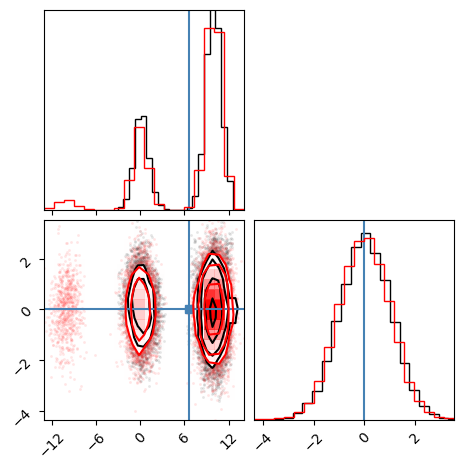

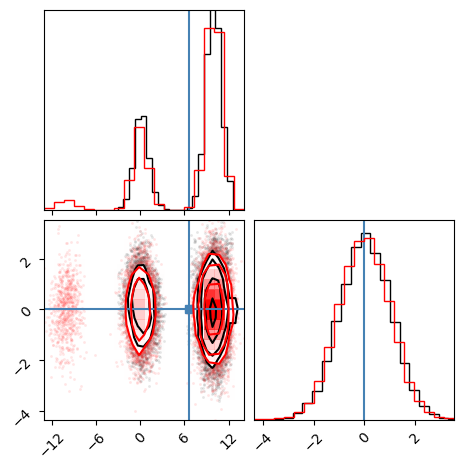

In [94]:
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-20000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock
corner.corner(bounded_iid_samples[-20000:], color='r', fig=fig, hist_kwargs={'density':True})

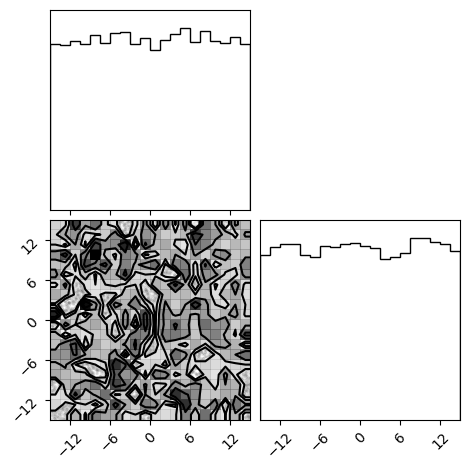

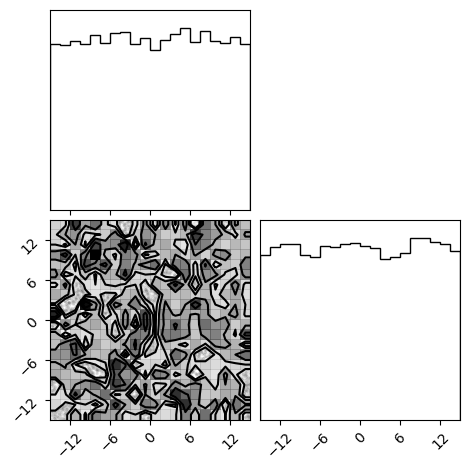

In [95]:
corner.corner(model._newDrawFromPrior(20000))

In [ ]:
# Pick up where we left off
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])

In [ ]:
# Plot samples
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection) # For taylorf2
# fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, truths=jnp.mean(bounded_iid_samples, axis=0)) # For rosenbrock

In [ ]:
# Keep going if needed
eps = 1e-6
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
# Keep going if needed
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
# Backup of scan
@partial(jax.jit, static_argnums=(1,2,3))
def ula_sampler_full_jax_jit(key, log_post, grad_log_post, n_iter, dt, x_0):

    # @progress_bar_scan(n_iter)
    def ula_step(carry, x):
        key, param = carry
        key, param = ula_kernel(key, param, log_post, grad_log_post, dt)
        return (key, param), param

    carry = (key, x_0)
    _, samples = jax.lax.scan(ula_step, carry, None, n_iter)
    return samples

In [ ]:
# With birth death process
n_iter = 300
n_particles = 300
eps = 1e-4
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)
outer_loop_num = 400
collect_outer_loop = 350
bandwidth = 0.01 # Compare with 0.001

X = []
# Run Langevin birth-death sampler
for i in range(outer_loop_num):
    sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)
    key, subkey = jax.random.split(key)
    X0 = sam[-1]
    V_X = model.getMinusLogPosterior_ensemble(X0)

    # Transform to unbounded space to perform birth-death
    Y, V_Y, _ = reparameterization(X0, V_X, jnp.zeros((n_particles, model.DoF)), model.lower_bound, model.upper_bound)

    Lambda, threshold = getLambdas(key, Y, V_Y, eps * n_iter, h=bandwidth)

    jumps, n_events = jump_logic(key, Lambda, threshold)

    print('n_events: %i' % n_events)

    X0 = X0[jumps]

    if i > collect_outer_loop:
        X.append(X0)


# Collect samples 
# print('Collecting samples')
# n_iter = 10000
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)

# # Plot samples
# reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))
# fig = corner.corner(reshaped_matrix[-200000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
119 * 300 *0.75

In [ ]:
np.array(X).shape

In [ ]:
samples = np.array(X).reshape(49 * 200, 5)
fig = corner.corner(samples, hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
n_iter = 100000
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])

In [ ]:
.shape

In [ ]:
fig = corner.corner(reshaped_matrix[-np.arange(1, 1000000)], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
a = ListDict(20)

In [ ]:
np.array(3) in a

In [ ]:
n_iter_collect = 100000
eps = 1e-6
sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter_collect, eps, sam[-1])

In [ ]:
sam.shape

In [ ]:
reshaped_matrix = sam.reshape((n_iter_collect * n_particles, model.DoF))
fig = corner.corner(reshaped_matrix[-100000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)

In [ ]:
# Setup parameters for sampling run
n_iter = 100
n_particles = 100
eps = 1e-5
X0 = model._newDrawFromPrior(n_particles)
key = jax.random.PRNGKey(0)

sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, X0)
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(jax.jacrev(model.potential_single)), n_iter, eps, X0)

# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), n_iter, eps, sam[-1])

# For Hybrid Rosenbrock
# sam = ula_sampler_full_jax_jit(key, jax.vmap(model.getMinusLogPosterior), jax.vmap(model.getGradientMinusLogPosterior), n_iter, eps, X0)

reshaped_matrix = sam.reshape((n_iter * n_particles, model.DoF))

In [ ]:
np.array(53).squeeze()

In [ ]:
key1, subkey = jax.random.split(key)

In [ ]:
key

In [ ]:
key1

In [ ]:
# For TaylorF2

# How to get samples skipped around?




fig = corner.corner(reshaped_matrix[-10000:], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)
# fig = corner.corner(reshaped_matrix[jnp.arange(-200000, -1, 5)], hist_kwargs={'density':True}, labels=model.index_label, truths=injection)


# For Hybrid Rosenbrock
# labels = [r'$x_{%i}$' % (i+1) for i in range(model.DoF)]
# fig = corner.corner(reshaped_matrix[-250000:], hist_kwargs={'density':True}, labels=labels)
# corner.corner(bounded_iid_samples[-30000:], color='r', fig=fig, hist_kwargs={'density':True})


In [ ]:
# JAX version of birth-death

# @partial(jax.jit, static_argnums=(1, 2))

# from src.reparameterization import reparameterization, logit, sigma_inv
# For TaylorF2 birth death on CPU

# pot = jax.vmap(model.gradient_potential_single)

# for i in range(10):
#     sam = ula_sampler_full_jax_jit(key, jax.vmap(model.potential_single), jax.vmap(model.gradient_potential_single), 100, eps, X0)

#     Y, V_Y, _ = reparameterization(sam[-1], pot(sam[-1]), 1, model.lower_bound, model.upper_bound)
#     gram = k_lp(Y)

#     key, subkey = jax.random.split(key)
#     idx, _ = birthDeathJumpIndicies(key, gram, V_Y)
#     # idx, _ = birthDeathJumpIndicies(sam[-1], k_lp, jax.vmap(model.potential_single))
#     X0 = sam[-1][idx]

def birthDeathJumpIndicies(key, kern_bd, V, tau=0.01):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    """
    nParticles = V.shape[0]

    # Get particles with significant mass discrepancy (1)
    # beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    # Lambda = beta - jnp.mean(beta) 

    # Get particles with significant mass discrepancy (2)
    tmp1 = jnp.mean(kern_bd, axis=1)
    Lambda = jnp.log(tmp1) + V
    Lambda = Lambda - jnp.mean(Lambda) - 1 + jnp.mean(kern_bd / tmp1, axis=1)

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    xi = jax.random.shuffle(key, jnp.argwhere(r < 1 - jnp.exp(-jnp.abs(Lambda) * tau), size=nParticles, fill_value=-1))

    # Particle jumps
    alive = jnp.full(nParticles, True)
    output = jnp.arange(nParticles)
    n_events = 0
    for i in xi:
        if i != -1 and alive[i]:
            n_events += 1
            if Lambda[i] > 0:
                alive[i] = False 
                j = jax.random.choice(key, jnp.arange(nParticles), p=alive)
                output[i] = j

            elif Lambda[i] < 0:
                alive[i] = False 
                j = jax.random.choice(key, jnp.arange(nParticles), p=alive)
                alive[i] = True 
                alive[j] = False
                output[j] = i 

    return output, n_events

In [ ]:
# key = jax.random.PRNGKey(0)
# n_particles = 200
# X0 = model._newDrawFromPrior(n_particles)
# gram = k_lp(X0)
# potentials = model.getMinusLogPosterior_ensemble(X0)

# Note: jumps contains an array of jump indicies and probabilities for alive/dead particles

def true_fun(i, j, jumps):
    jumps = jumps.at[0,i].set(j)
    jumps = jumps.at[1,i].set(0)
    return jumps

def false_fun(i, j, jumps):
    jumps = jumps.at[0,j].set(i) 
    jumps = jumps.at[1,j].set(0)
    return jumps

def scan_func(carry, x):
    key, jumps, Lambda = carry 
    pred = Lambda[x] > 0
    key, subkey = jax.random.split(key)
    j = jax.random.choice(key, Lambda.shape[0], p=jumps[1]) # Not choosing dead particles
    # j = jax.random.choice(key, Lambda.shape[0]) # TODO this is for debugging purposes. see if this is causing the slowdown!
    jumps = jax.lax.cond(x != -1, lambda: jax.lax.cond(pred, true_fun, false_fun, *(x, j, jumps)), lambda: jumps)
    return (key, jumps, Lambda), jumps

# @jax.jit
def birth_death_jumps(key, kern_bd, V, tau=0.01):
    """ 
    Remarks
    -------

    (1) Uses discrepancy from original paper
    (2) uses discrepancy from sequal paper

    """
    nParticles = V.shape[0]

    # Get particles with significant mass discrepancy (1)
    beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V
    Lambda = beta - jnp.mean(beta) 

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    threshold = r < 1 - jnp.exp(-jnp.abs(Lambda) * tau)
    idxs = jax.random.permutation(key, jnp.argwhere(threshold, size=nParticles, fill_value=-1).squeeze())

    jumps = jnp.zeros((2, nParticles), dtype=int)
    jumps = jumps.at[0].set(jnp.arange(nParticles))
    jumps = jumps.at[1].set(jnp.ones(nParticles, dtype=int))

    ### Using lax.scan function ### 
    init = (key, jumps, Lambda)
    jumps = jax.lax.scan(scan_func, init, idxs)

    ### Using python for loop ###
    # for i in idxs:
    #     key, subkey = jax.random.split(key)
    #     pred = Lambda[i] > 0
    #     j = jax.random.choice(key, nParticles, p=jumps[1])
    #     jumps = jax.lax.cond(i != -1, lambda: jax.lax.cond(pred, true_fun, false_fun, *(i, j, jumps)), lambda: jumps)

    # return threshold
    return jumps[0][1][0]
    # return jumps[0][1]


# a = birth_death_jumps(key, gram, potentials)





In [ ]:
# All computations to JIT compile
@jax.jit
def getLambdas(key, Y, V_Y, tau, h):

    # Lp kernel implementation
    def k_lp(X, p=2, h=0.001): 
        # Get separation vectors
        separation_vectors = X[:, jnp.newaxis, :] - X[jnp.newaxis, :, :]
        
        # Calculate kernel
        k = jnp.exp(-jnp.sum(jnp.abs(separation_vectors) ** p, axis=-1) / (p * h))
        return k

    kern_bd = k_lp(Y, h)

    # Get particles with significant mass discrepancy (1)
    beta = jnp.log(jnp.mean(kern_bd, axis=1)) + V_Y
    Lambda = beta - jnp.mean(beta) 

    # Calculate number of events
    r = jax.random.uniform(minval=0, maxval=1, shape=Lambda.shape, key=key)
    threshold = r < 1 - jnp.exp(-jnp.abs(Lambda) * tau)

    return Lambda, threshold

import random
class ListDict(object):
    """  
    Solution adapted from 
    https://stackoverflow.com/questions/15993447/python-data-structure-for-efficient-add-remove-and-random-choice
    Data structure with efficient
    (i)   lookup
    (ii)  uniform random selection
    (iii) removal

    """
    def __init__(self, nParticles):
        self.item_to_position = {}
        self.items = []
        for n in range(nParticles):
            self.add_item(n)

    def add_item(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove_item(self, item):
        position = self.item_to_position.pop(item)
        last_item = self.items.pop()
        if position != len(self.items):
            self.items[position] = last_item
            self.item_to_position[last_item] = position

    def choose_random_item(self):
        return random.choice(self.items)

    def __contains__(self, item):
        return item in self.item_to_position

    def __iter__(self):
        return iter(self.items)

    def __len__(self):
        return len(self.items)

# Jump logic
def jump_logic(key, Lambda, threshold):
    nParticles = Lambda.shape[0]
    alive = ListDict(nParticles)
    output = jnp.arange(Lambda.shape[0])
    xi = np.random.permutation(np.argwhere(threshold))[:,0]

    n_events = 0
    for i in xi:
        if i in alive:
            n_events += 1
            j = alive.choose_random_item()
            if Lambda[i] > 0:
                output = output.at[i].set(j)
                alive.remove_item(i)
            elif Lambda[i] < 0:
                output = output.at[j].set(i)
                alive.remove_item(j)
    return output, n_events